# Imports

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D,GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.models  import Sequential

# Converting Mood Videos into Mood Images

In [3]:
path = 'mood_images'
video_path = 'mood_videos'
moods = os.listdir(path)


def video_conv(video_files, save_folder):
    face_cascade = cv2.CascadeClassifier('D:\Git Clones\CPE-313\haarcascade\haarcascade_frontalface_default.xml')
    j = 1 #counter of saved images
    
    for file in video_files:
        print("Extracting",file)
        video = cv2.VideoCapture(file)
        if not video.isOpened():
            print(f"Error: Could not open video file {file}")
            continue
        i = 0
        while True:
            i += 1
            ret, frame = video.read()
            if i!=2: continue
            i = 0
            if not ret:
                break
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            faces = face_cascade.detectMultiScale(gray, 1.5, 5)

            for (x, y, w, h) in faces:
                roi_gray = gray[y:y + h, x:x + w]
                roi = cv2.resize(roi_gray, (224,224), interpolation=cv2.INTER_LINEAR)
                cv2.imwrite(os.path.join(save_folder, f'image_{j}.jpg'), roi)
                j += 1
        video.release()

for mood in moods:
  print(mood)
  files = os.listdir(f'{video_path}/{mood}')
  video_files = [os.path.join(video_path,mood,file) for file in files if file.endswith(('.mp4', '.avi', '.MOV'))]
  video_conv(video_files,f'{path}/{mood}')

Angry
Extracting mood_videos\Angry\Angry.mp4
Confused
Extracting mood_videos\Confused\Confused.mp4
Happy
Extracting mood_videos\Happy\Happy.mp4
Sad
Extracting mood_videos\Sad\Sad.mp4


# Image Generation

In [5]:
idg = ImageDataGenerator(rescale=1./255,
                         validation_split= 0.2,
                         )

train_gen = idg.flow_from_directory('mood_images', batch_size=32, 
                                    target_size=(224,224), 
                                    class_mode='categorical', 
                                    subset='training')

valid_gen = idg.flow_from_directory('mood_images', batch_size=32, 
                                    target_size=(224,224), 
                                    class_mode='categorical', 
                                    subset='validation')

Found 772 images belonging to 4 classes.
Found 191 images belonging to 4 classes.


# Building CNN from Scratch

In [11]:
model = Sequential()


model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (224, 224, 3)))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation = 'softmax'))

In [12]:
model.compile(loss='categorical_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

hist_1 = model.fit(train_gen, verbose = 1, epochs=20, validation_data = valid_gen)

Epoch 1/20
25/25 [==============================] - 8s 299ms/step - loss: 1.5700 - accuracy: 0.2772 - val_loss: 1.3718 - val_accuracy: 0.3298
Epoch 2/20
25/25 [==============================] - 8s 323ms/step - loss: 1.3491 - accuracy: 0.3549 - val_loss: 1.3036 - val_accuracy: 0.3298
Epoch 3/20
25/25 [==============================] - 7s 260ms/step - loss: 1.2980 - accuracy: 0.3834 - val_loss: 1.3248 - val_accuracy: 0.4712
Epoch 4/20
25/25 [==============================] - 7s 273ms/step - loss: 1.1725 - accuracy: 0.5013 - val_loss: 1.0678 - val_accuracy: 0.6021
Epoch 5/20
25/25 [==============================] - 7s 261ms/step - loss: 0.9144 - accuracy: 0.5764 - val_loss: 0.8467 - val_accuracy: 0.7277
Epoch 6/20
25/25 [==============================] - 7s 260ms/step - loss: 0.6949 - accuracy: 0.6865 - val_loss: 0.6057 - val_accuracy: 0.8063
Epoch 7/20
25/25 [==============================] - 9s 348ms/step - loss: 0.5839 - accuracy: 0.7642 - val_loss: 0.5506 - val_accuracy: 0.8796
Epoch 

# Testing

In [13]:
mood = ['Angry', 'Confused', 'Happy', 'Sad' ]
cascade = cv2.CascadeClassifier('D:\Git Clones\CPE-313\haarcascade\haarcascade_frontalface_default.xml')
camera = cv2.VideoCapture(0)

while True:
    ret, frame = camera.read()

    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    roi = cascade.detectMultiScale(gray, 1.3, 3)

    for (x,y,w,h) in roi:
        face = frame[y:y+h, x:x+w]
        face = cv2.resize(face, (224,224))
        face = np.expand_dims(face, axis = 0)

        pred = model.predict(face)
        label = np.argmax(pred)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, mood[label], (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    cv2.imshow('frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('q' or 'Q'):
        break

camera.release()
cv2.destroyAllWindows() 

1/1 [==============================] - 0s 21ms/step


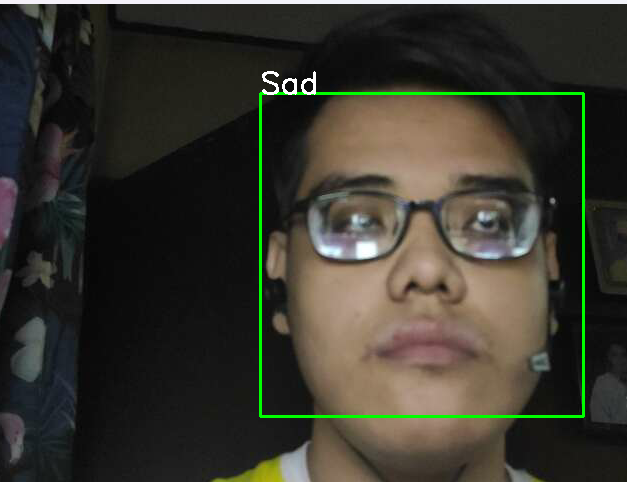

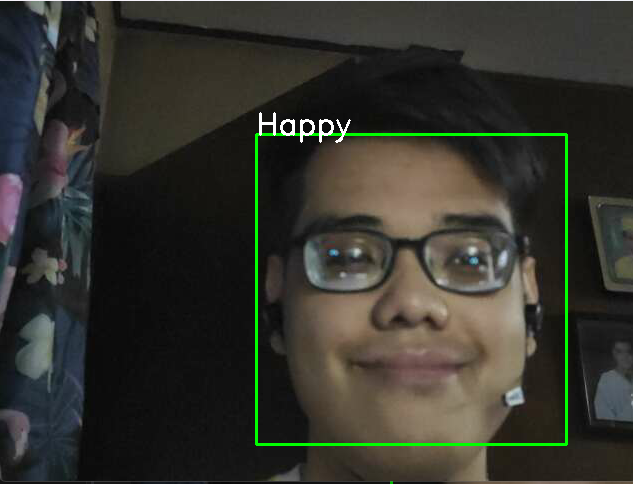

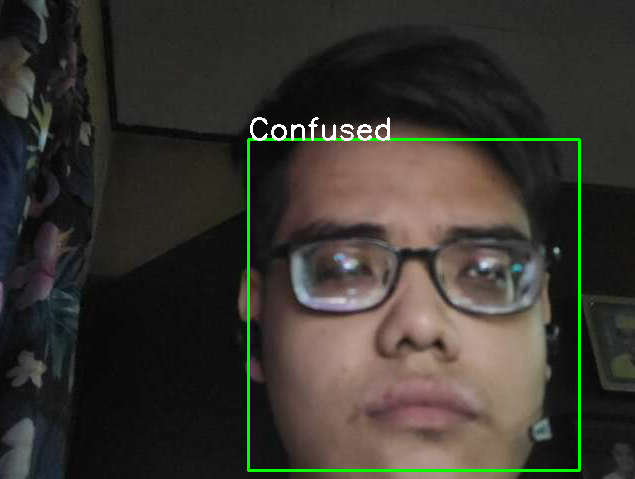

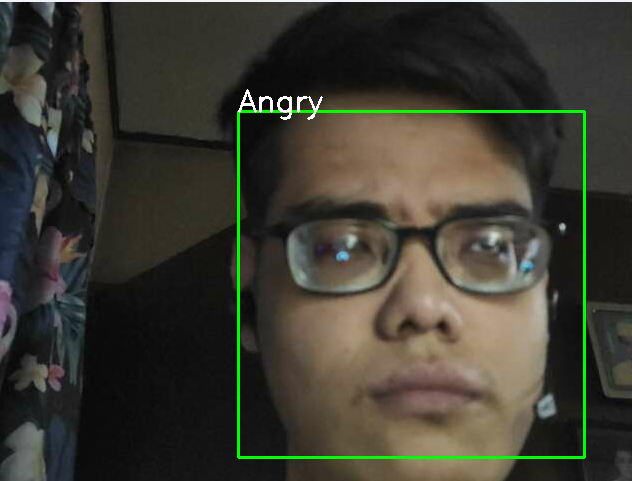